<a href="https://colab.research.google.com/github/JackBlake-zkq/robust-edge-inference/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fa_ensemble import FiniteAggregationEnsemble
from tilda import TILDA
from torchvision import transforms, datasets
import torch
from torch import nn, optim
import random
import numpy
from tqdm import tqdm
import ssl
from models.resnet import ResNet, ResNetSmall, ResNet18, ResNet34

import os
import matplotlib.pyplot as plt

### Explore Data Distribution

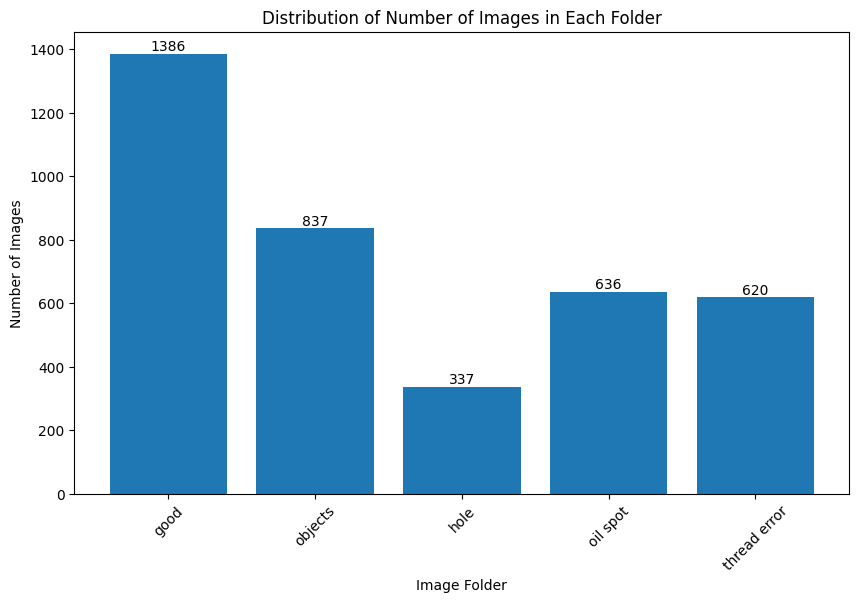

In [2]:
# https://www.kaggle.com/code/angelolmg/multiclass-classification

# Define the image folders
DATASET_ROOT = "datasets/TILDA400"
CLASSES = [
    'good',
    'objects',
    'hole',
    'oil spot',
    'thread error'
]

image_folders = [os.path.join(DATASET_ROOT, c) for c in CLASSES]
image_folders = [p.replace('/', os.path.sep) for p in image_folders] # make paths OS agnostic

# Function to count the number of images in a folder
def count_images_in_folder(folder_path):
    return len([file for file in os.listdir(folder_path) if file.endswith('.png')])

# Get the number of images in each folder
image_counts = [count_images_in_folder(folder) for folder in image_folders]

# Plot the distribution of the number of images inside each folder
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(image_folders)), image_counts)
plt.xticks(range(len(image_folders)), [os.path.basename(folder.rstrip(os.path.sep)) for folder in image_folders], rotation=45)
plt.xlabel('Image Folder')
plt.ylabel('Number of Images')
plt.title('Distribution of Number of Images in Each Folder')

# Add text labels with the exact number of images above each bar
for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.show()


# https://www.kaggle.com/code/stpeteishii/tilda-pytorch-lightning-cnn
# Reduce to 1000 random good images
# all_paths = {}
# removed_images_dir = os.path.join(DATASET_ROOT, 'good_removed')

# for dirname, _, filenames in os.walk(os.path.join(DATASET_ROOT, 'good')):
#     for filename in filenames:
#         all_paths.add(os.path.join(dirname, filename))

# removed_paths = all_paths.difference(dict(random.sample(all_paths,1000)))

# os.makedirs
# for path in removed_paths:

In [3]:
# https://www.kaggle.com/code/stpeteishii/tilda-pytorch-lightning-cnn
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(32),             # resize shortest side to 32 pixels
        transforms.CenterCrop(32),         # crop longest side to 32 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])


In [4]:
# if using the VisionDataset extension
# trainset = TILDA(transform=transform, test_ratio=0.2)
# testset = TILDA(transform=transform, test_ratio=0.2, is_test=True)

# using ImageFolder extension
data = TILDA(transform=transform)
dataset_size = len(data)
train_ratio = 0.8  # 80% train, 20% test
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Randomly split the dataset into train and test sets
trainset, testset = torch.utils.data.random_split(data, [train_size, test_size])


print(trainset, testset)

<torch.utils.data.dataset.Subset object at 0x1540af490> <torch.utils.data.dataset.Subset object at 0x1540af940>


In [14]:
def train_base_model(partition_number, train_subset):
    seed = partition_number
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    curr_lr = 0.01
    epochs = 500
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    device += ":" + str(partition_number)

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=1)
    print("subset has ", len(train_subset), "data points")
    
    ssl._create_default_https_context = ssl._create_unverified_context
    net = ResNet34()
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=curr_lr, momentum=1, weight_decay=0.0005, nesterov= True)

    # Training
    net.train()
    accuracies = []
    for epoch in tqdm(range(epochs)):
        correct, total = 0, 0
        for (inputs, targets) in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            break

        if (epoch in [60,120,160]):
            curr_lr = curr_lr * 0.2
            for param_group in optimizer.param_groups:
                param_group['lr'] = curr_lr
                
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

    plt.plot(accuracies)
    plt.show()        
    net.eval()

    nomtestloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=1)
    correct = 0
    total = 0
    for (inputs, targets) in nomtestloader:
        inputs, targets = inputs.to(device), targets.to(device)
        epoch_loss = []
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
        break
    acc = 100.*correct/total
    print(f'Estimated accuracy for base model {partition_number}: {str(acc)}%')

    return net


Training Base model 1 of 1..
subset has  3052 data points


100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


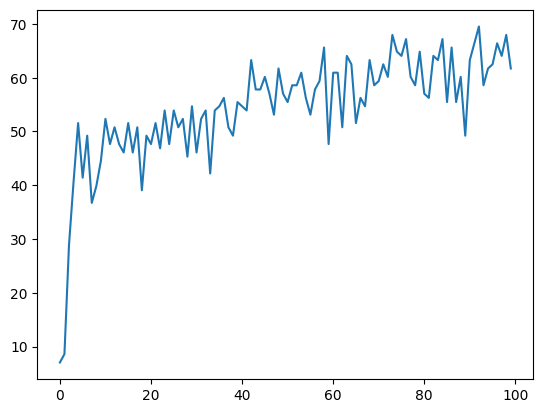

Estimated accuracy for base model 0: 63.28125%
Saving Base model 0..
Base model 0 saved


In [15]:
k = 1
d = 1
ensemble = FiniteAggregationEnsemble(trainset, testset, train_base_model, len(CLASSES), k=k, d=d, state_dir=f"tilda_k{k}_d{d}")
for i in range(k * d):
    ensemble.train_base_model(i)

In [13]:
ensemble.eval("softmax_median")

Generating base model predictions on testset...


  0%|          | 0/5 [00:07<?, ?it/s]


RuntimeError: The expanded size of the tensor (5) must match the existing size (10) at non-singleton dimension 1.  Target sizes: [763, 5].  Tensor sizes: [763, 10]

In [ ]:
ensemble.eval("logit_median")

testset predictions already computed, using those...
Certificates already computed, using those...
Base classifier accuracy: 97.14733333333334
Ensembe Accuracy: 98.11999999999999%
Certified Radius (for at least half of inputs): 15


In [ ]:
ensemble.eval(mode="label_voting")

testset predictions already computed, using those...
Certificates already computed, using those...
Base classifier accuracy: 97.14733333333334
Ensembe Accuracy: 98.06%
Certified Radius (for at least half of inputs): 15


In [ ]:
ensemble.distill(ResNetSmall(), 'softmax_median', lr=1e-3, epochs=5)

trainset predictions already computed, using those...


/Users/jackblake/Documents/UW_Courswork/robust-edge-inference/training/fa_ensemble.py:341: UserWarning: torch.sort is supported by MPS on MacOS 13+, please upgrade. Falling back to CPU (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Sort.mm:45.)
  softmaxes, _ = softmaxes_by_class.to(device).sort(dim=2)


Student for softmax_median distillation mode already trained
Evaluating Student


100%|██████████| 79/79 [00:05<00:00, 14.59it/s]

Accuracy for student: 97.88%


In [ ]:
ensemble.distill(ResNetSmall(), mode='logit_median', lr=1e-3, epochs=5)

trainset predictions already computed, using those...
Epoch 1/5


100%|██████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 2/5


100%|██████████| 469/469 [01:35<00:00,  4.89it/s]


Epoch 3/5


100%|██████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 4/5


100%|██████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 5/5


100%|██████████| 469/469 [01:36<00:00,  4.87it/s]


Finished training student, saving to ensembles/mnist_k30_d1/student_logit_median.pkl
Evaluating Student


100%|██████████| 79/79 [00:05<00:00, 14.67it/s]

Accuracy for student: 97.85%


In [ ]:
ensemble.distill(ResNetSmall(), 'label_voting', lr=1e-3, epochs=5)

trainset predictions already computed, using those...
Student for label_voting distillation mode already trained
Evaluating Student


100%|██████████| 79/79 [00:05<00:00, 14.55it/s]

Accuracy for student: 98.01%
